# Analyzing Coffee Chains In Chicago using Foursquare API

#### Importing neccessary libraries

In [1]:
import pandas as pd
import requests
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import json
#from pandas.io.json import json_normalize
from pandas import json_normalize

In [2]:
import time

In [48]:
import matplotlib

##### For showing complete columns and raws of datasets:

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Getting the coordinates of major neighborhoods in and around Downtown Chicago

In [4]:
address = ['Loop Chicago, IL', 'Gold Coast Chicago, IL', 
           'Streeterville Chicago, IL', 'South Loop Chicago, IL', 'West Loop Chicago, IL',
          'Old Town, Chicago, Il', 'Lincoln Park, Chicago, Il',
          'Pulaski Park, Chicago, Il', 'Near West Side, Chicago, Il',
          'West Side, Chicago, Il', 'China Town, Chicago, Il', 'Bridgeport, Chicago, Il',
          'Pilsen, Chicago, Il', 'Douglas, Chicago, Il', 'University Village, Chicago, Il',
          'East Village, Chicago, Il', 'Fuller Park, Chicago, Il', 'Oakland, Chicago, Il']
coor = []
for add in address:
    geolocator = Nominatim(user_agent="Chic_explorer")
    location = geolocator.geocode(add)
    #print(add, location.latitude, location.longitude)
    coor.append({'district': add, 'lat': location.latitude, 'long': location.longitude})
#    print('The geograpical coordinate of {} are {}, {}.'.format(address[add], coor.loc[add[0]], coor.loc[add[1]]))
coor_df = pd.DataFrame(coor)
coor_df.head()

,district,lat,long
0,"Loop Chicago, IL",41.881609,-87.629457
1,"Gold Coast Chicago, IL",41.906699,-87.625331
2,"Streeterville Chicago, IL",41.893402,-87.622001
3,"South Loop Chicago, IL",41.861785,-87.626121
4,"West Loop Chicago, IL",41.875562,-87.624421


#### Showing the neighborhoods locations on Chicago map

In [5]:
map_chicago = folium.Map(location=[coor_df.loc[0,'lat'], coor_df.loc[0,'long']], zoom_start=12)

# add markers to map
for lat, lng, label in zip(coor_df['lat'], coor_df['long'], coor_df['district']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

#### Collecting data of coffee chains in and around downtown Chicago using Foursquare API

In [6]:
CLIENT_ID = 'UGZGCRCGABM3LGAMOC05S3PDB0LC40GCBZQZ4ETHM3ZTXKFQ' # your Foursquare ID
CLIENT_SECRET = 'DKMN04CH3T0RKWOXNGHJQBJOI2Q3FRDQHSKLJSTSSMEN0XWH' # your Foursquare Secret
ACCESS_TOKEN = 'HMAOBXZBAQFVH0AKDVB014LO0554YWBQP4FNQU4V33NMCFKS' # your FourSquare Access Token
VERSION = '20210701'
LIMIT = 500
search_query = 'Coffee'
#radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UGZGCRCGABM3LGAMOC05S3PDB0LC40GCBZQZ4ETHM3ZTXKFQ
CLIENT_SECRET:DKMN04CH3T0RKWOXNGHJQBJOI2Q3FRDQHSKLJSTSSMEN0XWH


In [7]:
def getNearbyVenues(district, lat, long, radius=500):
    venue_list = []
    i = 0
    for district, lat, long in zip(district, lat, long):
        print(district)
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()['response']['venues']
        venue_list.append([(
                v['id'],
                district, 
                lat, 
                long, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
        nearby_venues.columns = ['ID','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
#del (downtown_venues)
downtown_venues = getNearbyVenues(district=coor_df['district'],
                                   lat=coor_df['lat'],
                                   long=coor_df['long']
                                  )

Loop Chicago, IL
Gold Coast Chicago, IL
Streeterville Chicago, IL
South Loop Chicago, IL
West Loop Chicago, IL
Old Town, Chicago, Il
Lincoln Park, Chicago, Il
Pulaski Park, Chicago, Il
Near West Side, Chicago, Il
West Side, Chicago, Il
China Town, Chicago, Il
Bridgeport, Chicago, Il
Pilsen, Chicago, Il
Douglas, Chicago, Il
University Village, Chicago, Il
East Village, Chicago, Il
Fuller Park, Chicago, Il
Oakland, Chicago, Il


In [9]:
first_column = downtown_venues.pop('Venue')
downtown_venues.insert(0, 'Venue', first_column)
print(downtown_venues.shape)
downtown_venues.head()

(105, 8)


,Venue,ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category
0,Intelligentsia Coffee,4a5bc165f964a520b9bb1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.884517,-87.625783,Coffee Shop
1,Dollop Coffee & Tea,5396301d498e2660782b078a,"Loop Chicago, IL",41.881609,-87.629457,41.876925,-87.628864,Coffee Shop
2,Peet's Coffee & Tea,544a7b1e498e333e2f59ecc7,"Loop Chicago, IL",41.881609,-87.629457,41.881823,-87.632870,Coffee Shop
3,Intelligentsia Coffee,49d51ce3f964a520675c1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.878092,-87.629615,Coffee Shop
4,Peet's Coffee & Tea,54060b96498ed2702c0632f7,"Loop Chicago, IL",41.881609,-87.629457,41.882467,-87.624686,Coffee Shop


In [10]:
downtown_venues.drop_duplicates(inplace = True, ignore_index = True)
downtown_venues.shape

(105, 8)

### Data Exploration

#### Determining number of coffee shops by neighborhood

In [16]:
shop_count = pd.DataFrame(downtown_venues.groupby('Neighborhood')['Venue'].count())

In [17]:
shop_count.rename(columns = {'Venue':'Coffee Shops'}, inplace = True)
shop_count.reset_index(inplace = True)
shop_count.head()

,Neighborhood,Coffee Shops
0,"Bridgeport, Chicago, Il",3
1,"Douglas, Chicago, Il",1
2,"Gold Coast Chicago, IL",2
3,"Lincoln Park, Chicago, Il",2
4,"Loop Chicago, IL",44


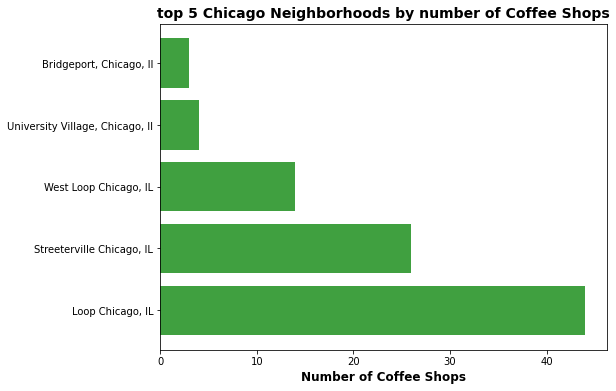

In [21]:
top_neighborhood = shop_count.sort_values('Coffee Shops', ascending = False)
fig = plt.figure(figsize =(8, 6))
plt.barh('Neighborhood','Coffee Shops', data = top_neighborhood.head(), color = 'green', alpha = .75)
plt.title('top 5 Chicago Neighborhoods by number of Coffee Shops', 
                fontsize = 14, fontweight ='bold')
plt.xlabel('Number of Coffee Shops', fontsize = 12, fontweight ='bold')
plt.show()

#### Determining the top coffee chain by number of chains

In [22]:
coffee_shops = downtown_venues.groupby('Venue')['Venue'].count()
top_coffee = pd.DataFrame(coffee_shops.sort_values(ascending = False).head(5))

In [23]:
top_coffee.rename(columns = {'Venue':'Branches'}, inplace = True)
top_coffee.reset_index(inplace = True)
top_coffee

,Venue,Branches
0,Starbucks,29
1,Hero Coffee Bar,5
2,Dollop Coffee & Tea,5
3,Intelligentsia Coffee,4
4,Peet's Coffee & Tea,4


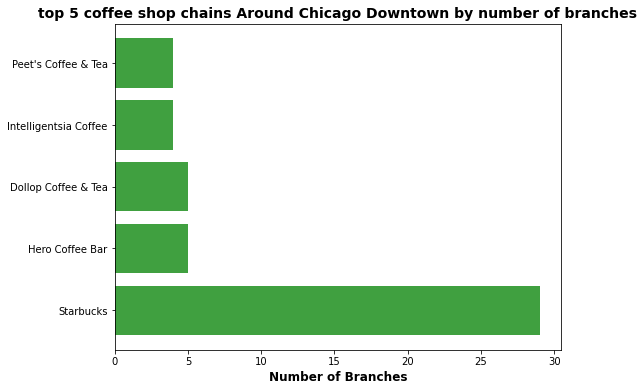

In [24]:
fig = plt.figure(figsize =(8, 6))
plt.barh('Venue','Branches', data = top_coffee, color = 'green', alpha = .75)
plt.title('top 5 coffee shop chains Around Chicago Downtown by number of branches', 
                fontsize = 14, fontweight ='bold')
plt.xlabel('Number of Branches', fontsize = 12, fontweight ='bold')
plt.show()

#### Showing coffee shops by brand on Downtown Chicago map. Starbucks is the dominating brand in terms of branches

In [25]:
map_coffee = folium.Map(location=[coor_df.loc[0,'lat'], coor_df.loc[0,'long']], zoom_start=15)

colors_array = cm.rainbow(np.linspace(0, 1, top_coffee.shape[0]))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label in zip(downtown_venues['Venue Latitude'], downtown_venues['Venue Longitude'], downtown_venues['Venue']):
    try:
        col = rainbow[top_coffee[top_coffee['Venue']==label].index[0]]
    except:
        col = 'grey'
        
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=col,
        fill = True,
        fill_color = col,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffee)  
    
map_coffee

#### Determining and visualizing the top rated coffee chains/shops in downtown Chicago

In [27]:
ratings = []
rated = 0
unrated = 0
for VID in downtown_venues['ID']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(VID, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    time.sleep(.5)
    result = requests.get(url).json()
    try:
        rating = result['response']['venue']['rating']
        ratings.append(rating)
        rated = rated + 1
    except:
        ratings.append('NaN')
        unrated = unrated + 1
print ('We have {} rated venues and {} unrated venues'.format(rated, unrated))
#ratings.head()

We have 67 rated venues and 38 unrated venues


In [28]:
downtown_venues['Ratings'] = ratings
downtown_venues.head()

,Venue,ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,Ratings
0,Intelligentsia Coffee,4a5bc165f964a520b9bb1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.884517,-87.625783,Coffee Shop,9.1
1,Dollop Coffee & Tea,5396301d498e2660782b078a,"Loop Chicago, IL",41.881609,-87.629457,41.876925,-87.628864,Coffee Shop,8.5
2,Peet's Coffee & Tea,544a7b1e498e333e2f59ecc7,"Loop Chicago, IL",41.881609,-87.629457,41.881823,-87.632870,Coffee Shop,7.8
3,Intelligentsia Coffee,49d51ce3f964a520675c1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.878092,-87.629615,Coffee Shop,8.4
4,Peet's Coffee & Tea,54060b96498ed2702c0632f7,"Loop Chicago, IL",41.881609,-87.629457,41.882467,-87.624686,Coffee Shop,8.3


In [29]:
venues_ratings = downtown_venues.dropna().reset_index()
venues_ratings['Ratings'] = round(venues_ratings['Ratings'].astype(float), 2)
venues_ratings = venues_ratings.dropna().reset_index()
coffee_ratings = venues_ratings.groupby('Venue')['Ratings'].mean()
best_coffee = pd.DataFrame(coffee_ratings.sort_values(ascending = False).head(5))

In [30]:
best_coffee.reset_index(inplace = True)
star = pd.DataFrame([['Starbucks', 6.99]], columns=['Venue', 'Ratings'])
best_coffee = pd.concat([best_coffee, star])
#best_coffee.rename(columns = {'Venue':'Branches'}, inplace = True)
best_coffee

,Venue,Ratings
0,La Colombe Coffee Roasters,9.20
1,Do-Rite Donuts & Chicken,9.00
2,Jackalope Coffee & Tea,8.90
3,Hotel Palomar,8.80
4,Cafecito,8.80
0,Starbucks,6.99


TypeError: set_xlim() missing 1 required positional argument: 'self'

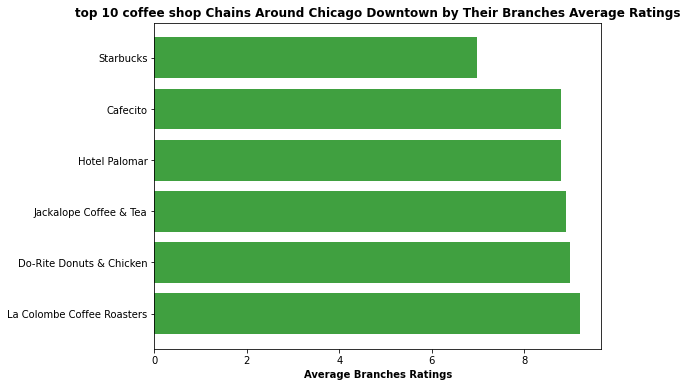

In [55]:
fig = plt.figure(figsize =(8, 6))
plt.barh('Venue','Ratings', data = best_coffee, color = 'green', alpha = .75)
plt.title('top 10 coffee shop Chains Around Chicago Downtown by Their Branches Average Ratings', 
                fontsize = 12, fontweight ='bold')
plt.xlabel('Average Branches Ratings', fontweight = 'bold')
plt.Axes.set_xlim(right = 10, left =5)
plt.show()

#### Exploring Starbucks ratings distribution

In [61]:
starbucks = downtown_venues[downtown_venues['Venue']=='Starbucks'].reset_index()
starbucks.rename(columns = {'Venue Latitude':'Latitude', 'Venue Longitude': 'Longitude'}, inplace = True)
starbucks.drop('index', axis = 1, inplace = True)
starbucks.head()

,Venue,ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Latitude,Longitude,Venue Category,Ratings
0,Starbucks,4bec0a73a9900f4744781840,"Loop Chicago, IL",41.881609,-87.629457,41.882818,-87.632493,Coffee Shop,7.7
1,Starbucks,4b969aa8f964a52006d834e3,"Loop Chicago, IL",41.881609,-87.629457,41.883350,-87.627362,Coffee Shop,7.9
2,Starbucks,4b182fd6f964a52089ce23e3,"Loop Chicago, IL",41.881609,-87.629457,41.882140,-87.630520,Coffee Shop,7.5
3,Starbucks,4a6cf09ff964a5201fd21fe3,"Loop Chicago, IL",41.881609,-87.629457,41.880790,-87.632140,Coffee Shop,6.7
4,Starbucks,4b10054af964a520946723e3,"Loop Chicago, IL",41.881609,-87.629457,41.885902,-87.628860,Coffee Shop,7.3


{'whiskers': [<matplotlib.lines.Line2D at 0x1cec2b6ebb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cec21552b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cec2b6e850>],
 'medians': [<matplotlib.lines.Line2D at 0x1cec2155970>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cec2172eb0>],
 'means': [<matplotlib.lines.Line2D at 0x1cec2155cd0>]}

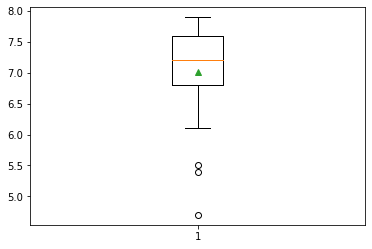

In [62]:
plt.boxplot(starbucks['Ratings'], showmeans = True)

In [63]:
starbucks1 = starbucks.drop(starbucks[starbucks['Ratings']<6].index)

{'whiskers': [<matplotlib.lines.Line2D at 0x22b1c0c5eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x22b1c0d15b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22b1c0c5b50>],
 'medians': [<matplotlib.lines.Line2D at 0x22b1c0d1c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x22b1c0dc370>],
 'means': [<matplotlib.lines.Line2D at 0x22b1c0d1fd0>]}

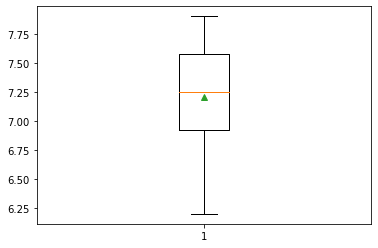

In [48]:
plt.boxplot(starbucks1['Ratings'], showmeans = True)

#### We discover that for some reason, three starbucks branches have unusual rating and are considered outliers.
#### we will drop those entries and check the best coffee brands by rating

In [64]:
venues_ratings1 = venues_ratings.drop(venues_ratings[(venues_ratings['Ratings']< 6) & (venues_ratings['Venue']=='Starbucks')].index)
#venues_ratings.drop(['index', 'level_0'], axis = 1)
coffee_ratings1 = venues_ratings1.groupby('Venue')['Ratings'].mean()
best_coffee1 = pd.DataFrame(coffee_ratings.sort_values(ascending = False).head(5))
best_coffee1

,Ratings
Venue,
La Colombe Coffee Roasters,9.2
Do-Rite Donuts & Chicken,9.0
Jackalope Coffee & Tea,8.9
Hotel Palomar,8.8
Cafecito,8.8


In [65]:
venues_ratings1.drop('index', axis = 1)
venues_ratings1.head()

,level_0,index,Venue,ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,Ratings
0,0,0,Intelligentsia Coffee,4a5bc165f964a520b9bb1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.884517,-87.625783,Coffee Shop,9.1
1,1,1,Dollop Coffee & Tea,5396301d498e2660782b078a,"Loop Chicago, IL",41.881609,-87.629457,41.876925,-87.628864,Coffee Shop,8.5
2,2,2,Peet's Coffee & Tea,544a7b1e498e333e2f59ecc7,"Loop Chicago, IL",41.881609,-87.629457,41.881823,-87.632870,Coffee Shop,7.8
3,3,3,Intelligentsia Coffee,49d51ce3f964a520675c1fe3,"Loop Chicago, IL",41.881609,-87.629457,41.878092,-87.629615,Coffee Shop,8.4
4,4,4,Peet's Coffee & Tea,54060b96498ed2702c0632f7,"Loop Chicago, IL",41.881609,-87.629457,41.882467,-87.624686,Coffee Shop,8.3


#### Exploring the top venues' categories that are at proximity of Starbucks

In [66]:
def getNearbyVenues(branches, latitudes, longitudes, radius=100):
    LIMIT = 15
    venues_list=[]
    for ID, lat, lng in zip(branches, latitudes, longitudes):
        #print(ID)
        time.sleep(.5)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            ID, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Branch ID',
                  'Branch Latitude', 
                  'Branc Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('We found {} venues near Starbucks'.format(nearby_venues.shape[0]))
    return(nearby_venues)

In [67]:
near_starbucks = getNearbyVenues(branches = starbucks['ID'], latitudes = starbucks['Latitude'], longitudes = starbucks['Longitude'])

We found 229 venues near Starbucks


In [68]:
print(near_starbucks.shape)
near_starbucks.head()

(229, 7)


,Branch ID,Branch Latitude,Branc Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4bec0a73a9900f4744781840,41.882818,-87.632493,Lotus Bahn Mi,41.883442,-87.633041,Vietnamese Restaurant
1,4bec0a73a9900f4744781840,41.882818,-87.632493,CorePower Yoga,41.883355,-87.632869,Yoga Studio
2,4bec0a73a9900f4744781840,41.882818,-87.632493,Starbucks,41.882818,-87.632493,Coffee Shop
3,4bec0a73a9900f4744781840,41.882818,-87.632493,Qdoba Mexican Grill,41.883395,-87.632670,Mexican Restaurant
4,4bec0a73a9900f4744781840,41.882818,-87.632493,California Pizza Kitchen,41.882839,-87.632896,Pizza Place


In [69]:
print('There are {} uniques categories.'.format(len(near_starbucks['Venue Category'].unique())))

There are 94 uniques categories.


In [70]:
starbucks_onehot = pd.get_dummies(near_starbucks[['Venue Category']], prefix="", prefix_sep="")

starbucks_onehot['ID'] = starbucks['ID'] 

fixed_columns = [starbucks_onehot.columns[-1]] + list(starbucks_onehot.columns[:-1])
starbucks_onehot = starbucks_onehot[fixed_columns]

starbucks_onehot.head()

,ID,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Building,Burger Joint,Burrito Place,Café,Camera Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Donut Shop,Dumpling Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Food Truck,Fried Chicken Joint,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hotel,Hotel Bar,Ice Cream Shop,Irish Pub,Italian Restaurant,Juice Bar,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Performing Arts Venue,Pet Service,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Sculpture Garden,Seafood Restaurant,Snack Place,South American Restaurant,Spanish Restaurant,Stationery Store,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,4bec0a73a9900f4744781840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4b969aa8f964a52006d834e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,4b182fd6f964a52089ce23e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4a6cf09ff964a5201fd21fe3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4b10054af964a520946723e3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
starbucks_grouped = starbucks_onehot.groupby('ID').mean().reset_index()
starbucks_grouped.head()

,ID,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Building,Burger Joint,Burrito Place,Café,Camera Store,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Donut Shop,Dumpling Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Court,Food Truck,Fried Chicken Joint,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Hotel,Hotel Bar,Ice Cream Shop,Irish Pub,Italian Restaurant,Juice Bar,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Performing Arts Venue,Pet Service,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Restaurant,Sake Bar,Salad Place,Sandwich Place,Sculpture Garden,Seafood Restaurant,Snack Place,South American Restaurant,Spanish Restaurant,Stationery Store,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,49d81b0ff964a520aa5d1fe3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4a6cf09ff964a5201fd21fe3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4a75ed06f964a520afe11fe3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4a88aa28f964a520540720e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4a993362f964a5207f2d20e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [73]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Venue'.format(ind+1))

# create a new dataframe
starbucks_venues_sorted = pd.DataFrame(columns=columns)
starbucks_venues_sorted['ID'] = starbucks_grouped['ID']

for ind in np.arange(starbucks_grouped.shape[0]):
    starbucks_venues_sorted.iloc[ind, 1:] = return_most_common_venues(starbucks_grouped.iloc[ind, :], num_top_venues)

starbucks_venues_sorted.head()

,ID,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,49d81b0ff964a520aa5d1fe3,Dumpling Restaurant,Toy / Game Store,American Restaurant,Pizza Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
1,4a6cf09ff964a5201fd21fe3,Mexican Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
2,4a75ed06f964a520afe11fe3,Hotel Bar,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
3,4a88aa28f964a520540720e3,Italian Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
4,4a993362f964a5207f2d20e3,Sandwich Place,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place


In [74]:
starbucks_venues_sorted['1st Venue'].value_counts(ascending = False).head()

Clothing Store        3
Hotel                 3
Coffee Shop           3
Department Store      1
Italian Restaurant    1
Name: 1st Venue, dtype: int64

In [75]:
starbucks_venues_sorted['2nd Venue'].value_counts(ascending = False).head()

American Restaurant    23
Pet Service             4
Toy / Game Store        1
Name: 2nd Venue, dtype: int64

In [76]:
starbucks_venues_sorted['3rd Venue'].value_counts(ascending = False).head()

Pet Service            12
Sculpture Garden        9
Sake Bar                4
American Restaurant     1
Sandwich Place          1
Name: 3rd Venue, dtype: int64

### Clustering Starbucks branches based on categories of neighboring venues

In [77]:
from sklearn.cluster import KMeans

In [119]:
starbucks_grouped_clustering = starbucks_grouped.drop('ID', 1)
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(starbucks_grouped_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 3, 0, 2, 2])

In [120]:
starbucks_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)

In [121]:
# add clustering labels
#starbucks_venues_sorted.drop(columns = 'Cluster Labels')
starbucks_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
starbucks_merged = starbucks
starbucks_merged = starbucks_merged.join(starbucks_venues_sorted.set_index('ID'), on='ID')
starbucks_merged.dropna(inplace = True)
starbucks_merged.head()

,Venue,ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Latitude,Longitude,Venue Category,Ratings,Cluster Labels,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Starbucks,4bec0a73a9900f4744781840,"Loop Chicago, IL",41.881609,-87.629457,41.882818,-87.632493,Coffee Shop,7.7,0,Vietnamese Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
1,Starbucks,4b969aa8f964a52006d834e3,"Loop Chicago, IL",41.881609,-87.629457,41.883350,-87.627362,Coffee Shop,7.9,4,Yoga Studio,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place,Plaza
2,Starbucks,4b182fd6f964a52089ce23e3,"Loop Chicago, IL",41.881609,-87.629457,41.882140,-87.630520,Coffee Shop,7.5,1,Coffee Shop,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
3,Starbucks,4a6cf09ff964a5201fd21fe3,"Loop Chicago, IL",41.881609,-87.629457,41.880790,-87.632140,Coffee Shop,6.7,0,Mexican Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
4,Starbucks,4b10054af964a520946723e3,"Loop Chicago, IL",41.881609,-87.629457,41.885902,-87.628860,Coffee Shop,7.3,0,Pizza Place,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place


In [122]:
#create map
map_clusters = folium.Map(location=[coor_df.loc[0,'lat'], coor_df.loc[0,'long']], zoom_start=13)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow[1]


markers_colors = []
for lat, lon, poi, cluster, rating in zip(starbucks_merged['Latitude'], starbucks_merged['Longitude'], starbucks_merged['Neighborhood'], starbucks_merged['Cluster Labels'], starbucks_merged['Ratings']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\n Rating' + str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Inspecting Clusters Attributes

#### Cluster 1

In [123]:
starbucks_merged.loc[starbucks_merged['Cluster Labels'] == 0, starbucks_merged.columns[[1] + [2] + list(range(10, starbucks_merged.shape[1]))]]

,ID,Neighborhood,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,4bec0a73a9900f4744781840,"Loop Chicago, IL",Vietnamese Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
3,4a6cf09ff964a5201fd21fe3,"Loop Chicago, IL",Mexican Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
4,4b10054af964a520946723e3,"Loop Chicago, IL",Pizza Place,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
5,4b1c7145f964a520660724e3,"Loop Chicago, IL",Performing Arts Venue,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place,Plaza
6,49d81b0ff964a520aa5d1fe3,"Loop Chicago, IL",Dumpling Restaurant,Toy / Game Store,American Restaurant,Pizza Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
8,4b82eaa6f964a52008ed30e3,"Loop Chicago, IL",Department Store,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
10,4b6818bbf964a52010672be3,"Loop Chicago, IL",American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place,Plaza
11,4cc5d54d306e224bf95ea56c,"Loop Chicago, IL",New American Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
12,4b1f3826f964a520ee2424e3,"Loop Chicago, IL",Women's Store,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
16,4a88aa28f964a520540720e3,"Streeterville Chicago, IL",Italian Restaurant,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place


In [124]:
starbucks_merged.loc[starbucks_merged['Cluster Labels'] == 1, starbucks_merged.columns[[1] + [2] + list(range(10, starbucks_merged.shape[1]))]]

,ID,Neighborhood,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
2,4b182fd6f964a52089ce23e3,"Loop Chicago, IL",Coffee Shop,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
9,4b9e45f0f964a52082d636e3,"Loop Chicago, IL",Coffee Shop,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
15,4aeed96ff964a5205fd421e3,"Gold Coast Chicago, IL",Coffee Shop,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant


In [93]:
starbucks_merged.loc[starbucks_merged['Cluster Labels'] == 2, starbucks_merged.columns[[1] + [2] + list(range(10, starbucks_merged.shape[1]))]]

,ID,Neighborhood,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
7,4adf22fbf964a520ce7721e3,"Loop Chicago, IL",Clothing Store,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
13,4adc77c5f964a520782c21e3,"Loop Chicago, IL",Clothing Store,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant
14,4b07001ef964a52016f522e3,"Loop Chicago, IL",Clothing Store,American Restaurant,Sculpture Garden,Salad Place,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant


In [117]:
starbucks_merged.loc[starbucks_merged['Cluster Labels'] == 3, starbucks_merged.columns[[1] + [2] + list(range(10, starbucks_merged.shape[1]))]]

,ID,Neighborhood,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
17,4b191a94f964a52002d823e3,"Streeterville Chicago, IL",Hotel,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
21,4b8870b0f964a520eff731e3,"Streeterville Chicago, IL",Hotel,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place
22,4abbedf0f964a5208c8520e3,"Streeterville Chicago, IL",Hotel,American Restaurant,Pet Service,Sake Bar,Restaurant,Ramen Restaurant,Public Art,Pub,Portuguese Restaurant,Poke Place


## tests

In [94]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, '41.881609', '-87.629457', ACCESS_TOKEN, VERSION, search_query, '100', '10')
results = requests.get(url).json()['response']['venues']
results

[{'id': '57693f2b498e2878c657453d',
  'name': 'Dollop Coffee & Tea',
  'location': {'address': '55 W Monroe St',
   'crossStreet': 'Dearborn',
   'lat': 41.88094589993328,
   'lng': -87.62970504510251,
   'labeledLatLngs': [{'label': 'display',
     'lat': 41.88094589993328,
     'lng': -87.62970504510251}],
   'distance': 76,
   'postalCode': '60603',
   'cc': 'US',
   'city': 'Chicago',
   'state': 'IL',
   'country': 'United States',
   'formattedAddress': ['55 W Monroe St (Dearborn)',
    'Chicago, IL 60603',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1e0931735',
    'name': 'Coffee Shop',
    'pluralName': 'Coffee Shops',
    'shortName': 'Coffee Shop',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
     'suffix': '.png'},
    'primary': True}],
  'delivery': {'id': '2756460',
   'url': 'https://www.grubhub.com/restaurant/dollop-coffee-co-55-w-monroe-st-chicago/2756460?affiliate=1131&utm_source=foursquare-affiliate-network&utm

In [30]:
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format('4a5bc165f964a520b9bb1fe3', CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result = requests.get(url).json()
result
#rating = result['response']['venue']['rating']
#rating

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '611032c89c83d67862e5557c'},
 'response': {}}